In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import GradientBoostingRegressor

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [2]:
dowhy.__version__

'0.14'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 08

In this chapter we focus on the assumptions we need to meet when working with causal inference. The chapter is of great importance as causal inference relies heavily on these assumptions and not meeting them might lead to biased results. We discuss positivity and exchangeability assumptions. Next, we discuss other assumptions. In the last part of the chapter we focus on unobserved variables and discuss them from yet another angle.

## Not Enough Data - The Experiment

### Graph

In [4]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['S', 'Q', 'X', 'Y', 'P']
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

### Experiment

In [7]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# Ignore specific statsmodels warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore")

In [8]:
# Define the true effect
TRUE_EFFECT = .7

# Define experiment params
sample_sizes = [30, 100, 1000, 10000]
noise_coefs = [.1, .2, .3, .4, .5, .6, .7, .8]
n_samples = 20

# Record the results
results = []

# Run the experiment
for sample_size in tqdm(sample_sizes):
    for noise_coef in noise_coefs:
        for i in range(n_samples):
        
            # Generate the data
            S = np.random.random(sample_size)
            Q = 0.2*S + noise_coef*np.random.random(sample_size)
            X = 0.14*Q + noise_coef*np.random.random(sample_size)
            Y = TRUE_EFFECT*X + 0.11*Q + 0.32*S + noise_coef*np.random.random(sample_size)
            P = 0.43*X + 0.21*Y + noise_coef*np.random.random(sample_size)

            # Encode as a pandas df
            df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

            # Instantiate the CausalModel 
            model = CausalModel(
                data=df,
                treatment='X',
                outcome='Y',
                graph=gml_string
            )

            # Get the estimand
            estimand = model.identify_effect()

            # Get estimate (DML)
            estimate_dml = model.estimate_effect(
                identified_estimand=estimand,
                method_name='backdoor.econml.dml.DML',
                method_params={
                    'init_params': {
                        'model_y': GradientBoostingRegressor(),
                        'model_t': GradientBoostingRegressor(),
                        'model_final': LassoCV(fit_intercept=False),
                    },
                    'fit_params': {}}
            )   

            # Get estimate (Linear Regression)
            estimate_lr = model.estimate_effect(
                identified_estimand=estimand,
                method_name='backdoor.linear_regression')

            results.append(
                {
                    'sample_size': sample_size,
                    'noise_coef': noise_coef,
                    'estimate_dml': estimate_dml.value,
                    'estimate_lr': estimate_lr.value,
                    'error_dml': estimate_dml.value - TRUE_EFFECT,
                    'error_lr': estimate_lr.value - TRUE_EFFECT
                }
            )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:11<00:00, 47.89s/it]


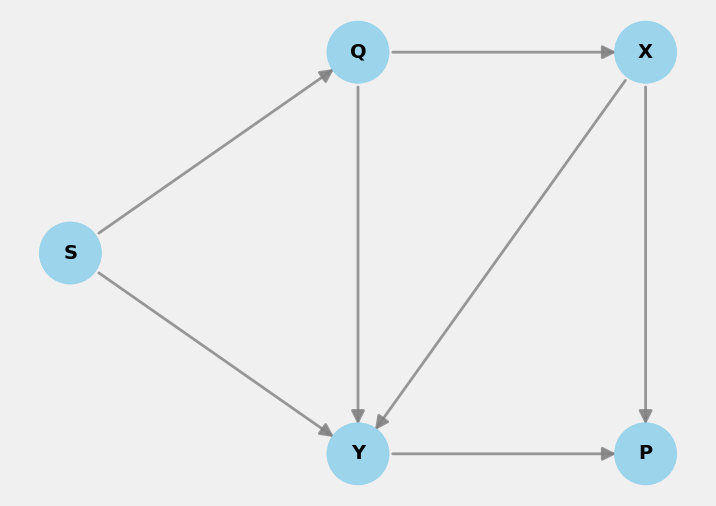

In [9]:
model.view_model()

In [12]:
results_df = pd.DataFrame(results)

In [13]:
results_df

,sample_size,noise_coef,estimate_dml,estimate_lr,error_dml,error_lr
0,30,0.1,1.340144,0.991026,0.640144,0.291026
1,30,0.1,0.512035,0.466868,-0.187965,-0.233132
2,30,0.1,1.058829,1.025102,0.358829,0.325102
3,30,0.1,0.517518,0.765134,-0.182482,0.065134
4,30,0.1,0.615789,0.139668,-0.084211,-0.560332
...,...,...,...,...,...,...
635,10000,0.8,0.692778,0.696702,-0.007222,-0.003298
636,10000,0.8,0.715761,0.716917,0.015761,0.016917
637,10000,0.8,0.712056,0.709815,0.012056,0.009815
638,10000,0.8,0.702563,0.704254,0.002563,0.004254


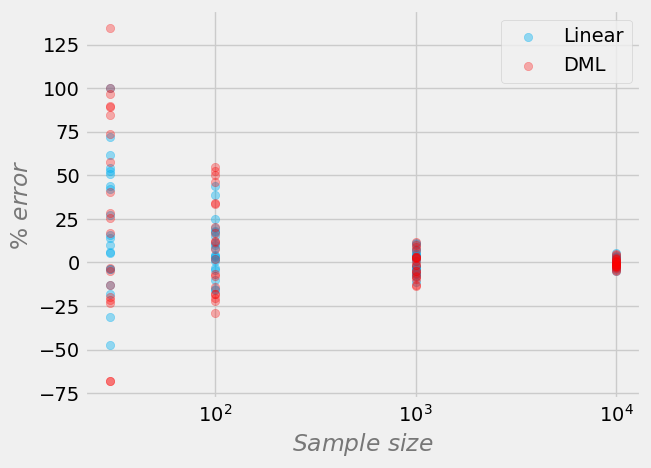

In [14]:
plt.scatter(
    results_df[results_df['noise_coef'] == .3]['sample_size'],
    (results_df[results_df['noise_coef'] == .3]['error_lr'] / TRUE_EFFECT) * 100,
    color=COLORS[0],
    alpha=.4,
    label='Linear'
)

plt.scatter(
    results_df[results_df['noise_coef'] == .3]['sample_size'],
    (results_df[results_df['noise_coef'] == .3]['error_dml'] / TRUE_EFFECT) * 100,
    color=COLORS[1],
    alpha=.3,
    label='DML'
)




plt.xscale('log')
plt.legend()
plt.xlabel('$Sample$ $size$', alpha=.5)
plt.ylabel('% $error$', alpha=.5)
plt.show()

## Positivity Assumption - An Example

In [15]:
# Helpers
def get_y(z, t):
    return z + .2 * z**2 + 10*np.sin(z) + 9*t

### Bad case

In [16]:
# Set X values
z_t0 = np.random.uniform(2, 5, 30)
z_t1 = np.random.uniform(5.2, 9, 30)

In [17]:
# Compute Y
y_t0 = get_y(z_t0, 0)
y_t1 = get_y(z_t1, 1)

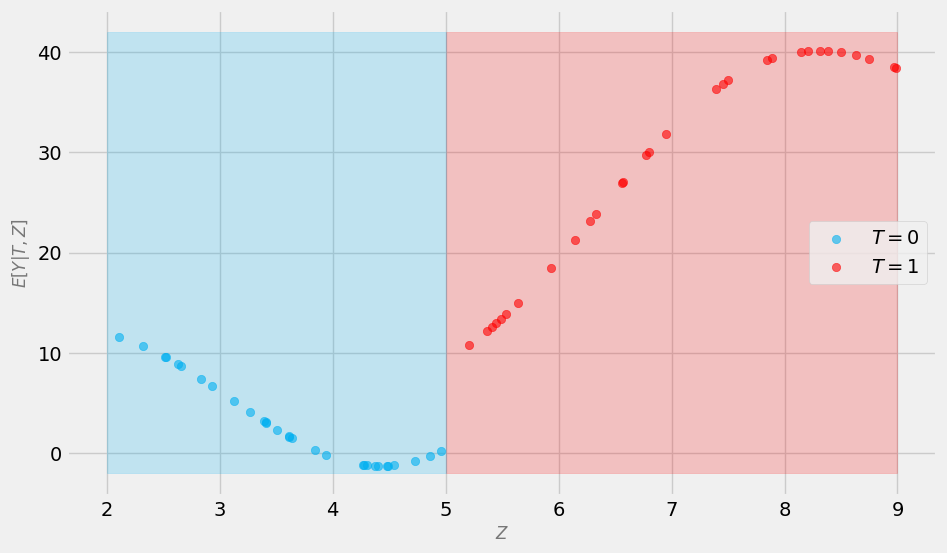

In [18]:
plt.figure(figsize=(10, 6))

plt.fill_betweenx([-2, 42], 5, 9, color=COLORS[1], alpha=.2)
plt.fill_betweenx([-2, 42], 2, 5, color=COLORS[0], alpha=.2)

plt.scatter(z_t0, y_t0, color=COLORS[0], label='$T=0$', alpha=.6)
plt.scatter(z_t1, y_t1, color=COLORS[1], label='$T=1$', alpha=.6)

plt.xlabel('$Z$', alpha=.5, fontsize=12)
plt.ylabel('$E[Y|T, Z]$', alpha=.5, fontsize=12)

plt.legend()
plt.show()

### Good case

In [19]:
# Set X values
z_t0 = np.random.uniform(2, 9, 30)
z_t1 = np.random.uniform(2, 9, 30)

# Compute Y
y_t0 = get_y(z_t0, 0)
y_t1 = get_y(z_t1, 1)

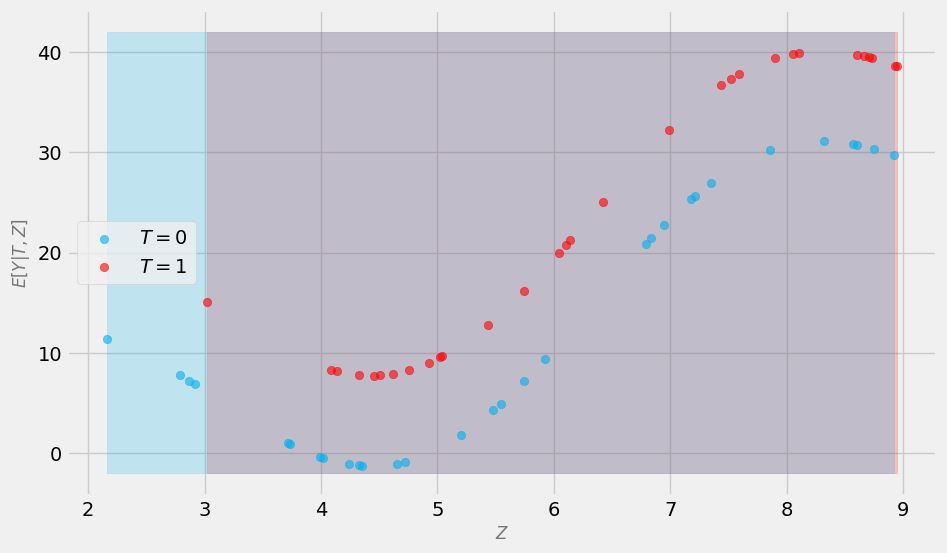

In [20]:
plt.figure(figsize=(10, 6))

plt.fill_betweenx([-2, 42], min(z_t1), max(z_t1), color=COLORS[1], alpha=.2)
plt.fill_betweenx([-2, 42], min(z_t0), max(z_t0), color=COLORS[0], alpha=.2)

plt.scatter(z_t0, y_t0, color=COLORS[0], label='$T=0$', alpha=.6)
plt.scatter(z_t1, y_t1, color=COLORS[1], label='$T=1$', alpha=.6)

plt.xlabel('$Z$', alpha=.5, fontsize=12)
plt.ylabel('$E[Y|T, Z]$', alpha=.5, fontsize=12)

plt.legend()
plt.show()

## Modularity

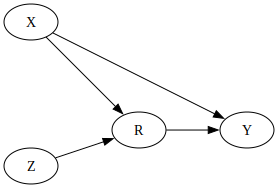

In [21]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'R', 'Z']
positions = ['1,2!', '4,.5!', '2.5,.5!', '1, 0!']

edges = ['XR', 'ZR', 'RY', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_modularity')

graph

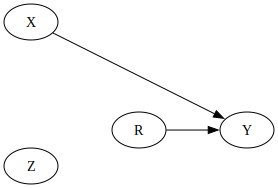

In [22]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'R', 'Z']
positions = ['1,2!', '4,.5!', '2.5,.5!', '1, 0!']

edges = ['RY', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_modularity_mod')

graph

## Selection Bias: Missing Holes & Abraham Wald

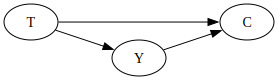

In [23]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C']
positions = ['0,.5!', '1.5,0!', '3,.5!']

edges = ['TY', 'TC', 'YC']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection')

graph

In [24]:
SAMPLE_SIZE = 1000

# A hypothetical SCM
T = np.random.uniform(20, 110, SAMPLE_SIZE)
Y = T + np.random.uniform(0, 40, SAMPLE_SIZE)
C = (T + Y < 100).astype('int')

In [25]:
df = pd.DataFrame(np.stack([T, Y, C]).T, columns=['T', 'Y', 'C'])

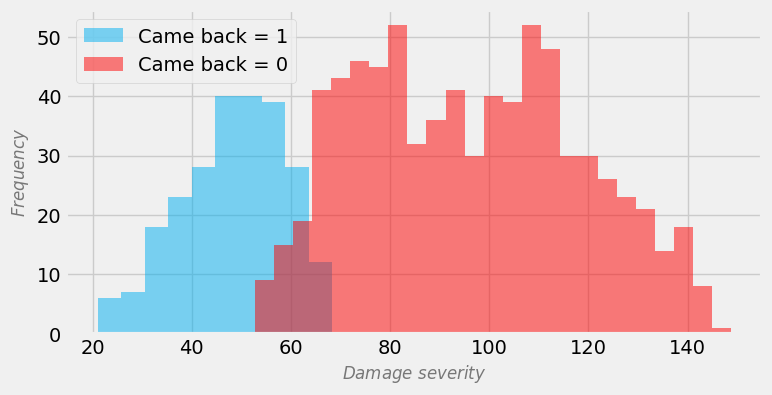

In [26]:
# Compare average damage (biased vs unbiased)
plt.figure(figsize=(8, 4))

plt.hist(df[df['C'] == 1]['Y'], label='Came back = 1', color=COLORS[0], alpha=.5)
plt.hist(df[df['C'] == 0]['Y'], label='Came back = 0', color=COLORS[1], alpha=.5, bins=25)

plt.xlabel('$Damage$ $severity$', alpha=.5, fontsize=12)
plt.ylabel('$Frequency$', alpha=.5, fontsize=12)

plt.legend()
plt.show()

## More selection bias

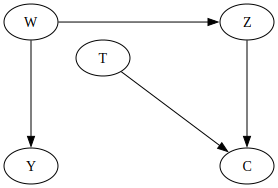

In [27]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C', 'Z', 'W']
positions = ['1.,1.5!', '0,0!', '3,0!', '3,2!', '0,2!']

edges = ['ZC', 'TC', 'WZ', 'WY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection_02')

graph

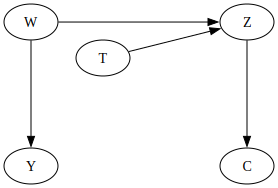

In [28]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C', 'Z', 'W']
positions = ['1.,1.5!', '0,0!', '3,0!', '3,2!', '0,2!']

edges = ['TZ', 'ZC', 'WZ', 'WY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection_03')

graph